In [416]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import Galactic, ICRS
from astropy import units as u
from modules.velocity_transformations import equatorial_UVW
from modules.vr_opt import VrOpt
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import normalized_mutual_info_score
import hdbscan
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph, sort_graph_by_row_values

from Distant_SigMA.SigMA.SigMA import SigMA
from scipy.stats import norm
from math import ceil
from scipy.stats import gaussian_kde
from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.optimize import curve_fit
from modules.vr_opt import VrOpt
import nbimporter
import clustering_algorithm
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from mpl_toolkits.mplot3d import Axes3D

# Generate mock data

In [417]:
# Plotting related stuff
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:grey']
zorders = [2, 2, 2, 2, 2, 1]
alphas = [0.9, 0.9, 0.9, 0.9, 0.9, 0.3]
log = True

In [418]:
# Create 6D Gaussian data
np.random.seed(42) 
n = 1000
X_bg = (np.random.rand(n*5, 6) - 0.5) * 50 #background dataset of random points uniformly distributed 6D

mu = np.array([-5, 5, 5, 5, -5, 5]) #first 3 for average position of the Cluster in 3D(XYZ). Last 3 for average velocities in (VxVyVz)
c_xx = c_yy = 20 #Variance of the average in x and y.
c_xy = 15 
c_zz = 3
c_uvw = 1
cov = np.diag([c_xx, c_yy, c_zz, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy #makes positive correlation of x and y
# Add signal
X_sig_1 = np.random.multivariate_normal(mu, cov, n//2) #generate n/2 data points based on mu and cov

# Second cluster
mu_2 = np.array([5, -5, -5, -5, 5, -5])
c_xx_2 = c_yy = 20
c_xy_2 = -15
c_zz_2 = 3
cov = np.diag([c_xx_2, c_yy, c_zz_2, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy_2
X_sig_2 = np.random.multivariate_normal(mu_2, cov, n//2)

# Additional clusters' parameters
# Cluster 3
mu_3 = np.array([-12, 10, -10, -10, 15, -18])
c_xx_3 = c_yy_3 = 25 # More spread in X-Y plane
c_xy_3 = 10
c_zz_3 = 4
cov_3 = np.diag([c_xx_3, c_yy_3, c_zz_3, c_uvw, c_uvw, c_uvw])
cov_3[0, 1] = cov_3[1, 0] = c_xy_3
X_sig_3 = np.random.multivariate_normal(mu_3, cov_3, n//2)

# Cluster 4
mu_4 = np.array([-11, -10, 13, -7, -7, 18])
c_xx_4 = c_yy_4 = 30
c_xy_4 = -12
c_zz_4 = 5
cov_4 = np.diag([c_xx_4, c_yy_4, c_zz_4, c_uvw, c_uvw, c_uvw])
cov_4[0, 1] = cov_4[1, 0] = c_xy_4
X_sig_4 = np.random.multivariate_normal(mu_4, cov_4, n//2)

# Cluster 5
mu_5 = np.array([10, 10, 15, 10, -15, -20])
c_xx_5 = c_yy_5 = 32
c_xy_5 = 8
c_zz_5 = 6
cov_5 = np.diag([c_xx_5, c_yy_5, c_zz_5, c_uvw, c_uvw, c_uvw])
cov_5[0, 1] = cov_5[1, 0] = c_xy_5
X_sig_5 = np.random.multivariate_normal(mu_5, cov_5, n//2)

X = np.concatenate([X_bg, X_sig_1, X_sig_2, X_sig_3, X_sig_4, X_sig_5], axis=0) #5000 bg stars, and 5*500 cluster stars
labels = np.concatenate([np.zeros(n*5), np.ones(n//2), np.ones(n//2)*2, np.ones(n//2)*3, np.ones(n//2)*4, np.ones(n//2)*5])

df = pd.DataFrame(X, columns=['x', 'y', 'z', 'vx', 'vy', 'vz'])
# Transform to spherical coordinates
gal_coords = Galactic(
    u=df.x.values * u.pc,
    v=df.y.values * u.pc,
    w=df.z.values * u.pc,
    # velocities UVW
    U=df.vx.values * u.km / u.s,
    V=df.vy.values * u.km / u.s,
    W=df.vz.values * u.km / u.s,
    representation_type="cartesian",
    # Velocity representation
    differential_type="cartesian",
)
# transform to ICRS
icrs_coords = gal_coords.transform_to(ICRS())
icrs_coords.representation_type = "spherical"

ra = icrs_coords.ra.value
dec = icrs_coords.dec.value
dist = icrs_coords.distance.value
pmra = icrs_coords.pm_ra.value * np.cos(np.deg2rad(dec))
pmdec = icrs_coords.pm_dec.value
rv_calc = icrs_coords.radial_velocity.value

df['ra'] = ra
df['dec'] = dec
df['dist'] = dist
df['pmra'] = pmra
df['pmdec'] = pmdec
df['radial_velocity'] = rv_calc

df['vt_ra'] = df.pmra * df.dist * 4.74
df['vt_dec'] = df.pmdec * df.dist * 4.74

idx_cluster_1 = np.where(labels==1)[0]
idx_cluster_2 = np.where(labels==2)[0]
idx_cluster_3 = np.where(labels==3)[0]
idx_cluster_4 = np.where(labels==4)[0]
idx_cluster_5 = np.where(labels==5)[0]
idx_bg = np.where(labels==0)[0]

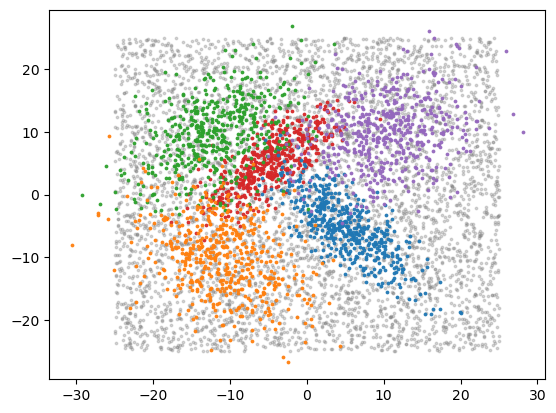

In [461]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'vx', 'vy'
#x_col, y_col = 'vt_ra', 'vt_dec'
#x_col, y_col = 'pmra', 'pmdec'
for idx_sel, alpha, c, zo in zip([idx_cluster_1, idx_cluster_2, idx_cluster_3, idx_cluster_4, idx_cluster_5, idx_bg], alphas, colors, zorders): 
    plt.scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s=3, c=c, alpha=alpha, zorder=zo)
    
    #scatter more in uvw 

In [456]:
U, V, W = equatorial_UVW(
    ra,
    dec,
    pmra,
    pmdec,
    rv_calc,
    dist,
)
# Check if the transformation is correct
np.allclose(U, df.vx.values, atol=1e-1), np.allclose(V, df.vy.values, atol=1e-1), np.allclose(W, df.vz.values, atol=1e-1)
print(df)
df.to_csv('data.csv', index=False)


              x          y          z         vx         vy         vz  \
0     -6.272994  22.535715  11.599697   4.932924 -17.199068 -17.200274   
1    -22.095819  18.308807   5.055751  10.403629 -23.970775  23.495493   
2     16.622132 -14.383044 -15.908752 -15.829775  -9.787888   1.237822   
3     -3.402749 -10.438543   5.592645 -18.025307 -10.392768  -6.681908   
4     -2.196501  14.258798 -15.016311   0.711722   4.620728 -22.677479   
...         ...        ...        ...        ...        ...        ...   
7495   0.318430   0.648008  14.767137  10.876024 -15.135884 -18.447722   
7496   5.940312  12.321013  16.776978   8.326091 -16.844013 -20.403112   
7497  18.546338  17.914509   9.237268  10.856226 -14.866233 -20.159990   
7498   4.620124  10.868567  16.013856   9.148356 -15.105983 -20.323542   
7499  14.467780   3.492152  17.611243  10.321478 -14.846155 -20.956594   

              ra        dec       dist        pmra       pmdec  \
0     281.680238  74.477071  26.110571   59.7

# Apply initial clustering of SigMa 

In [421]:
knn_list=[15, 20, 25, 30]
cluster_features = ['x', 'y','z'] #In which variables you want to cluster
sigma_kwargs = dict(
        cluster_features=cluster_features,
        nb_resampling=0,
        max_knn_density=int(np.max(knn_list)+1),
        beta=0.99,
        knn_initcluster_graph=35
    )

In [422]:
#make SigMA object
clusterer = SigMA(
            data=df,
            scale_factors=None, #needed for clustering in different spaces with scaling differences
            **sigma_kwargs
        )
knn_list=[15, 20, 25, 30]
cluster_features = ['x', 'y','z'] #In which variables you want to cluster
sigma_kwargs = dict(
        cluster_features=cluster_features,
        nb_resampling=0,
        max_knn_density=int(np.max(knn_list)+1),
        beta=0.99,
        knn_initcluster_graph=35
    )

In [423]:
#DO THE INITIAL CLUSTERS WITHOUT THE MERGING STEP OF RUN_SIGMA FUNCTION
clusterer.initialize_clustering(knn=20) #initialen cluster erstellt
clusterer.initialize_mode_neighbor_dict() #diese funktionen und mergeclusterer in parameters.py beschrieben
clusterer.resample_k_distances()# Compute k-distances for re-sampled data sets
leaf_labels = clusterer.leaf_labels_ 

Performing gradient ascend using a 20-NN density estimation.


In [424]:
np.unique(leaf_labels, return_counts = True) #the unique labels and how many in each leaf 

(array([  73,  114,  169,  189,  238,  279,  311,  427,  495,  507,  660,
         690,  722,  754,  855,  864,  994,  999, 1010, 1028, 1034, 1041,
        1102, 1145, 1222, 1254, 1286, 1325, 1378, 1388, 1392, 1414, 1536,
        1557, 1611, 1735, 1952, 2036, 2088, 2108, 2130, 2182, 2187, 2213,
        2232, 2362, 2400, 2556, 2564, 2567, 2593, 2678, 2712, 2769, 2779,
        2832, 2982, 3140, 3170, 3248, 3261, 3377, 3385, 3435, 3437, 3527,
        3551, 3602, 3613, 3690, 3704, 3776, 3781, 3788, 3890, 3894, 3904,
        3999, 4051, 4209, 4258, 4280, 4307, 4361, 4440, 4442, 4500, 4522,
        4553, 4564, 4599, 4696, 4911, 4988, 5010, 5203, 5247, 5404, 5485,
        5537, 5575, 5589, 5615, 5620, 5701, 5723, 5741, 6061, 6177, 6291,
        6329, 6370, 6442, 6473, 6570, 6640, 6662, 6691, 6696, 6726, 6817,
        6974, 7039, 7050, 7068, 7072, 7164, 7293, 7300, 7330, 7468, 7475],
       dtype=int64),
 array([ 20,  21,  24,  60,  11,  41,  31,  37,  63,  56,  32,  41,   3,
         38,  56,

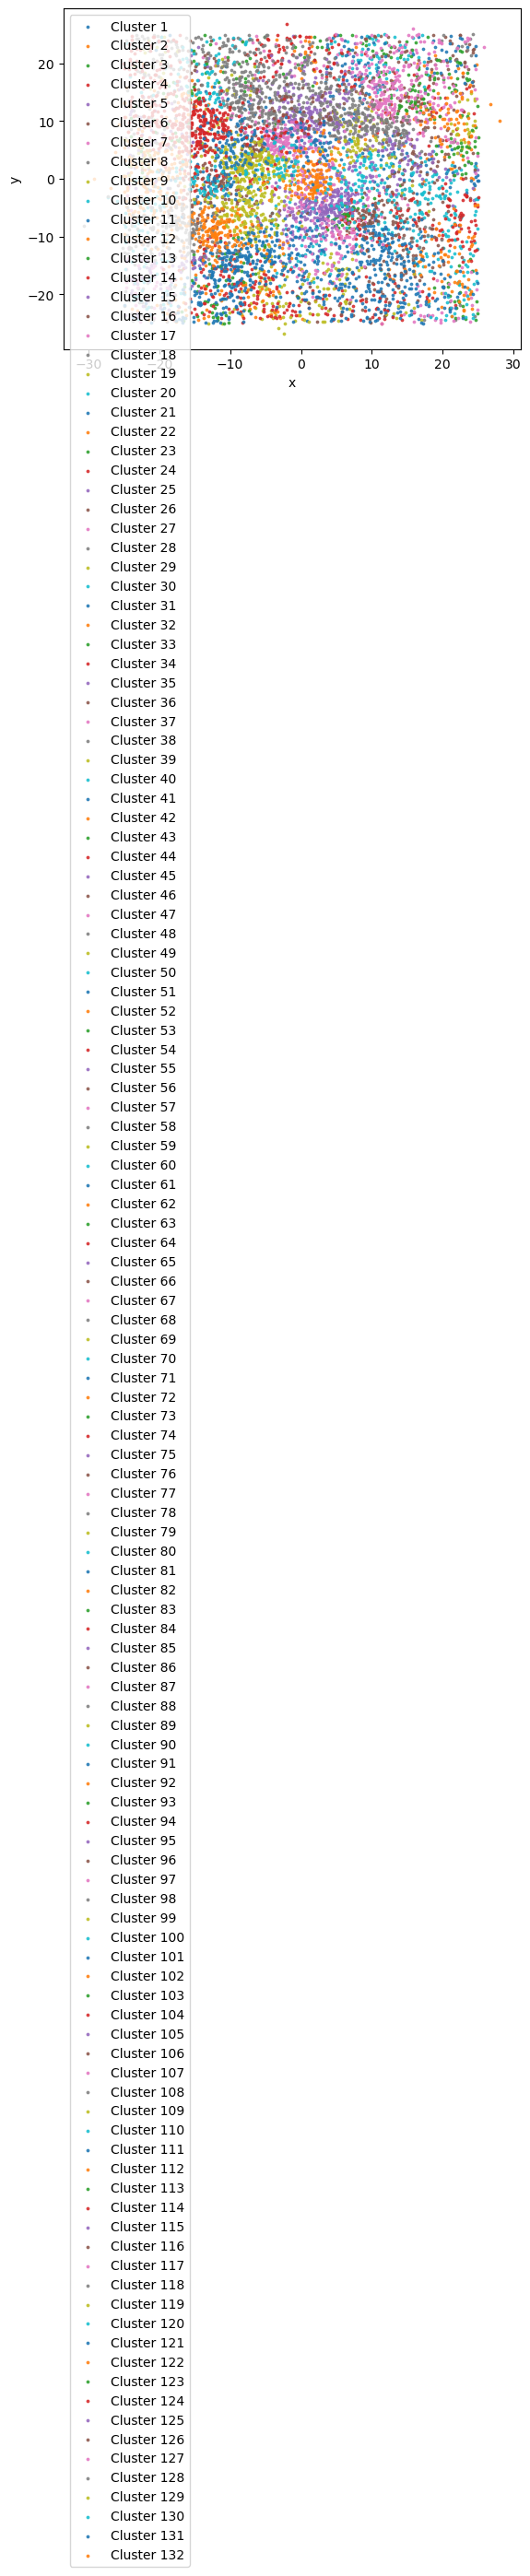

In [425]:
x_col, y_col = 'x', 'y'
#x_col, y_col = 'vx', 'vy'
#x_col, y_col = 'vt_ra', 'vt_dec'
#x_col, y_col = 'pmra', 'pmdec'

for i, label in enumerate(np.unique(leaf_labels)):
    cluster_idx = np.where(leaf_labels == label)[0]  # Get the indices of the current cluster
    plt.scatter(df.loc[cluster_idx, x_col], df.loc[cluster_idx, y_col], 
                s=3, label=f'Cluster {i+1}', alpha=0.8)

# Add plot labels and title
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.legend()
plt.show()

# Create initial fine partition:  
Explore hierachy, look into the parameters class (merge_clusters). 
Use run_sigma with -infinity, get pvalues and sort them by icreasing size. 
run mergeclusters fct over and over again using different pvalues (np array distribution btw 0 and 1 zoom in o close to 0 and you get individual values. Choose alpha to be btw the pvalues. whats the center. 
vizualize what it looks like as fct of the alpha value.

In [426]:
#RUN SIGMA WITH P-VALUES
labels_s, pvalues = clusterer.run_sigma(alpha=-np.infty,knn=20,return_pvalues= True) 
sorted_pvalues = sorted(pvalues)

Text(0, 0.5, 'Density')

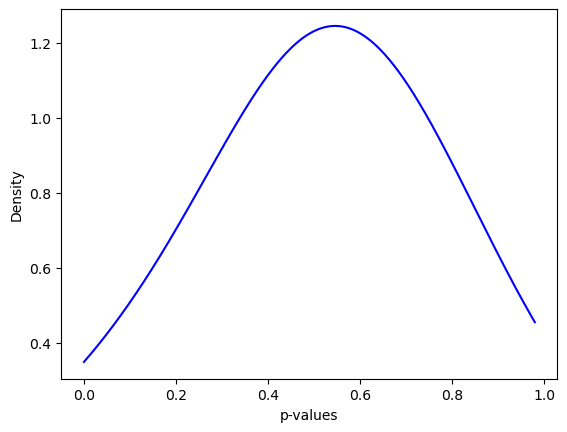

In [427]:
#PLOT DISTRIBUTION OF P-VALUES
mu = np.mean(sorted_pvalues)     
sigma = np.std(sorted_pvalues)    

# Compute the KDE
kde = gaussian_kde(sorted_pvalues, bw_method=1)

x_values = np.linspace(min(sorted_pvalues), max(sorted_pvalues), 500)
density = kde(x_values)

# Plot the normal distribution curve
plt.plot(x_values, density, color='blue')

plt.xlabel('p-values')
plt.ylabel('Density')

In [428]:
# zoom in in the region close to 0
###Ein kleinerer p-Wert bedeutet, dass die beobachteten Daten sehr unwahrscheinlich wären, wenn die Nullhypothese zutrifft###
lower_pvalues = [x for x in sorted_pvalues if x <= 0.2]
#make a list of alpha values that are the centers between all these pvalues
alpha_values = [(lower_pvalues[i] + lower_pvalues[i+1]) / 2 for i in range(len(lower_pvalues) - 1)]
print(lower_pvalues)
print(alpha_values) #Signifikanzniveau

[0.0, 5.440092820663267e-14, 1.6172618799714655e-12, 1.568280616481843e-09, 0.016700930074704634, 0.017553601917735917, 0.031842593647468664, 0.043202230125614305, 0.051768360269643265, 0.10147914717421291, 0.11391455598253164, 0.14192958097087294, 0.1541988300467101, 0.1784120065647128, 0.194718254015933, 0.19943555434454896]
[2.7200464103316335e-14, 8.358314040890491e-13, 7.849489391809072e-10, 0.008350465821492625, 0.017127265996220276, 0.02469809778260229, 0.037522411886541485, 0.047485295197628785, 0.07662375372192809, 0.10769685157837228, 0.1279220684767023, 0.1480642055087915, 0.16630541830571144, 0.1865651302903229, 0.19707690418024099]


[5485 5701]
[5485 5701 6473]
[5485 5701 6473 7293]
[5485 5701 6473 6974 7293]
[3776 5485 5701 6473 6974 7293]
[3776 5485 5701 6473 6817 6974 7293]
[3776 5485 5589 5701 6473 6817 6974 7293]
[3776 3894 5485 5589 5701 6473 6817 6974 7293]
[3776 3894 5010 5485 5589 5701 6473 6817 6974 7293]
[ 427 3776 3894 5010 5485 5589 5701 6473 6817 6974 7293]
[ 427 3776 3894 5010 5203 5485 5589 5701 6473 6817 6974 7293]
[ 427 3776 3894 5010 5203 5247 5485 5589 5701 6473 6817 6974 7293]
[ 427 3776 3788 3894 5010 5203 5247 5485 5589 5701 6473 6817 6974 7293]
[ 427 2036 3776 3788 3894 5010 5203 5247 5485 5589 5701 6473 6817 6974
 7293]
[ 427 2036 2769 3776 3788 3894 5010 5203 5247 5485 5589 5701 6473 6817
 6974 7293]


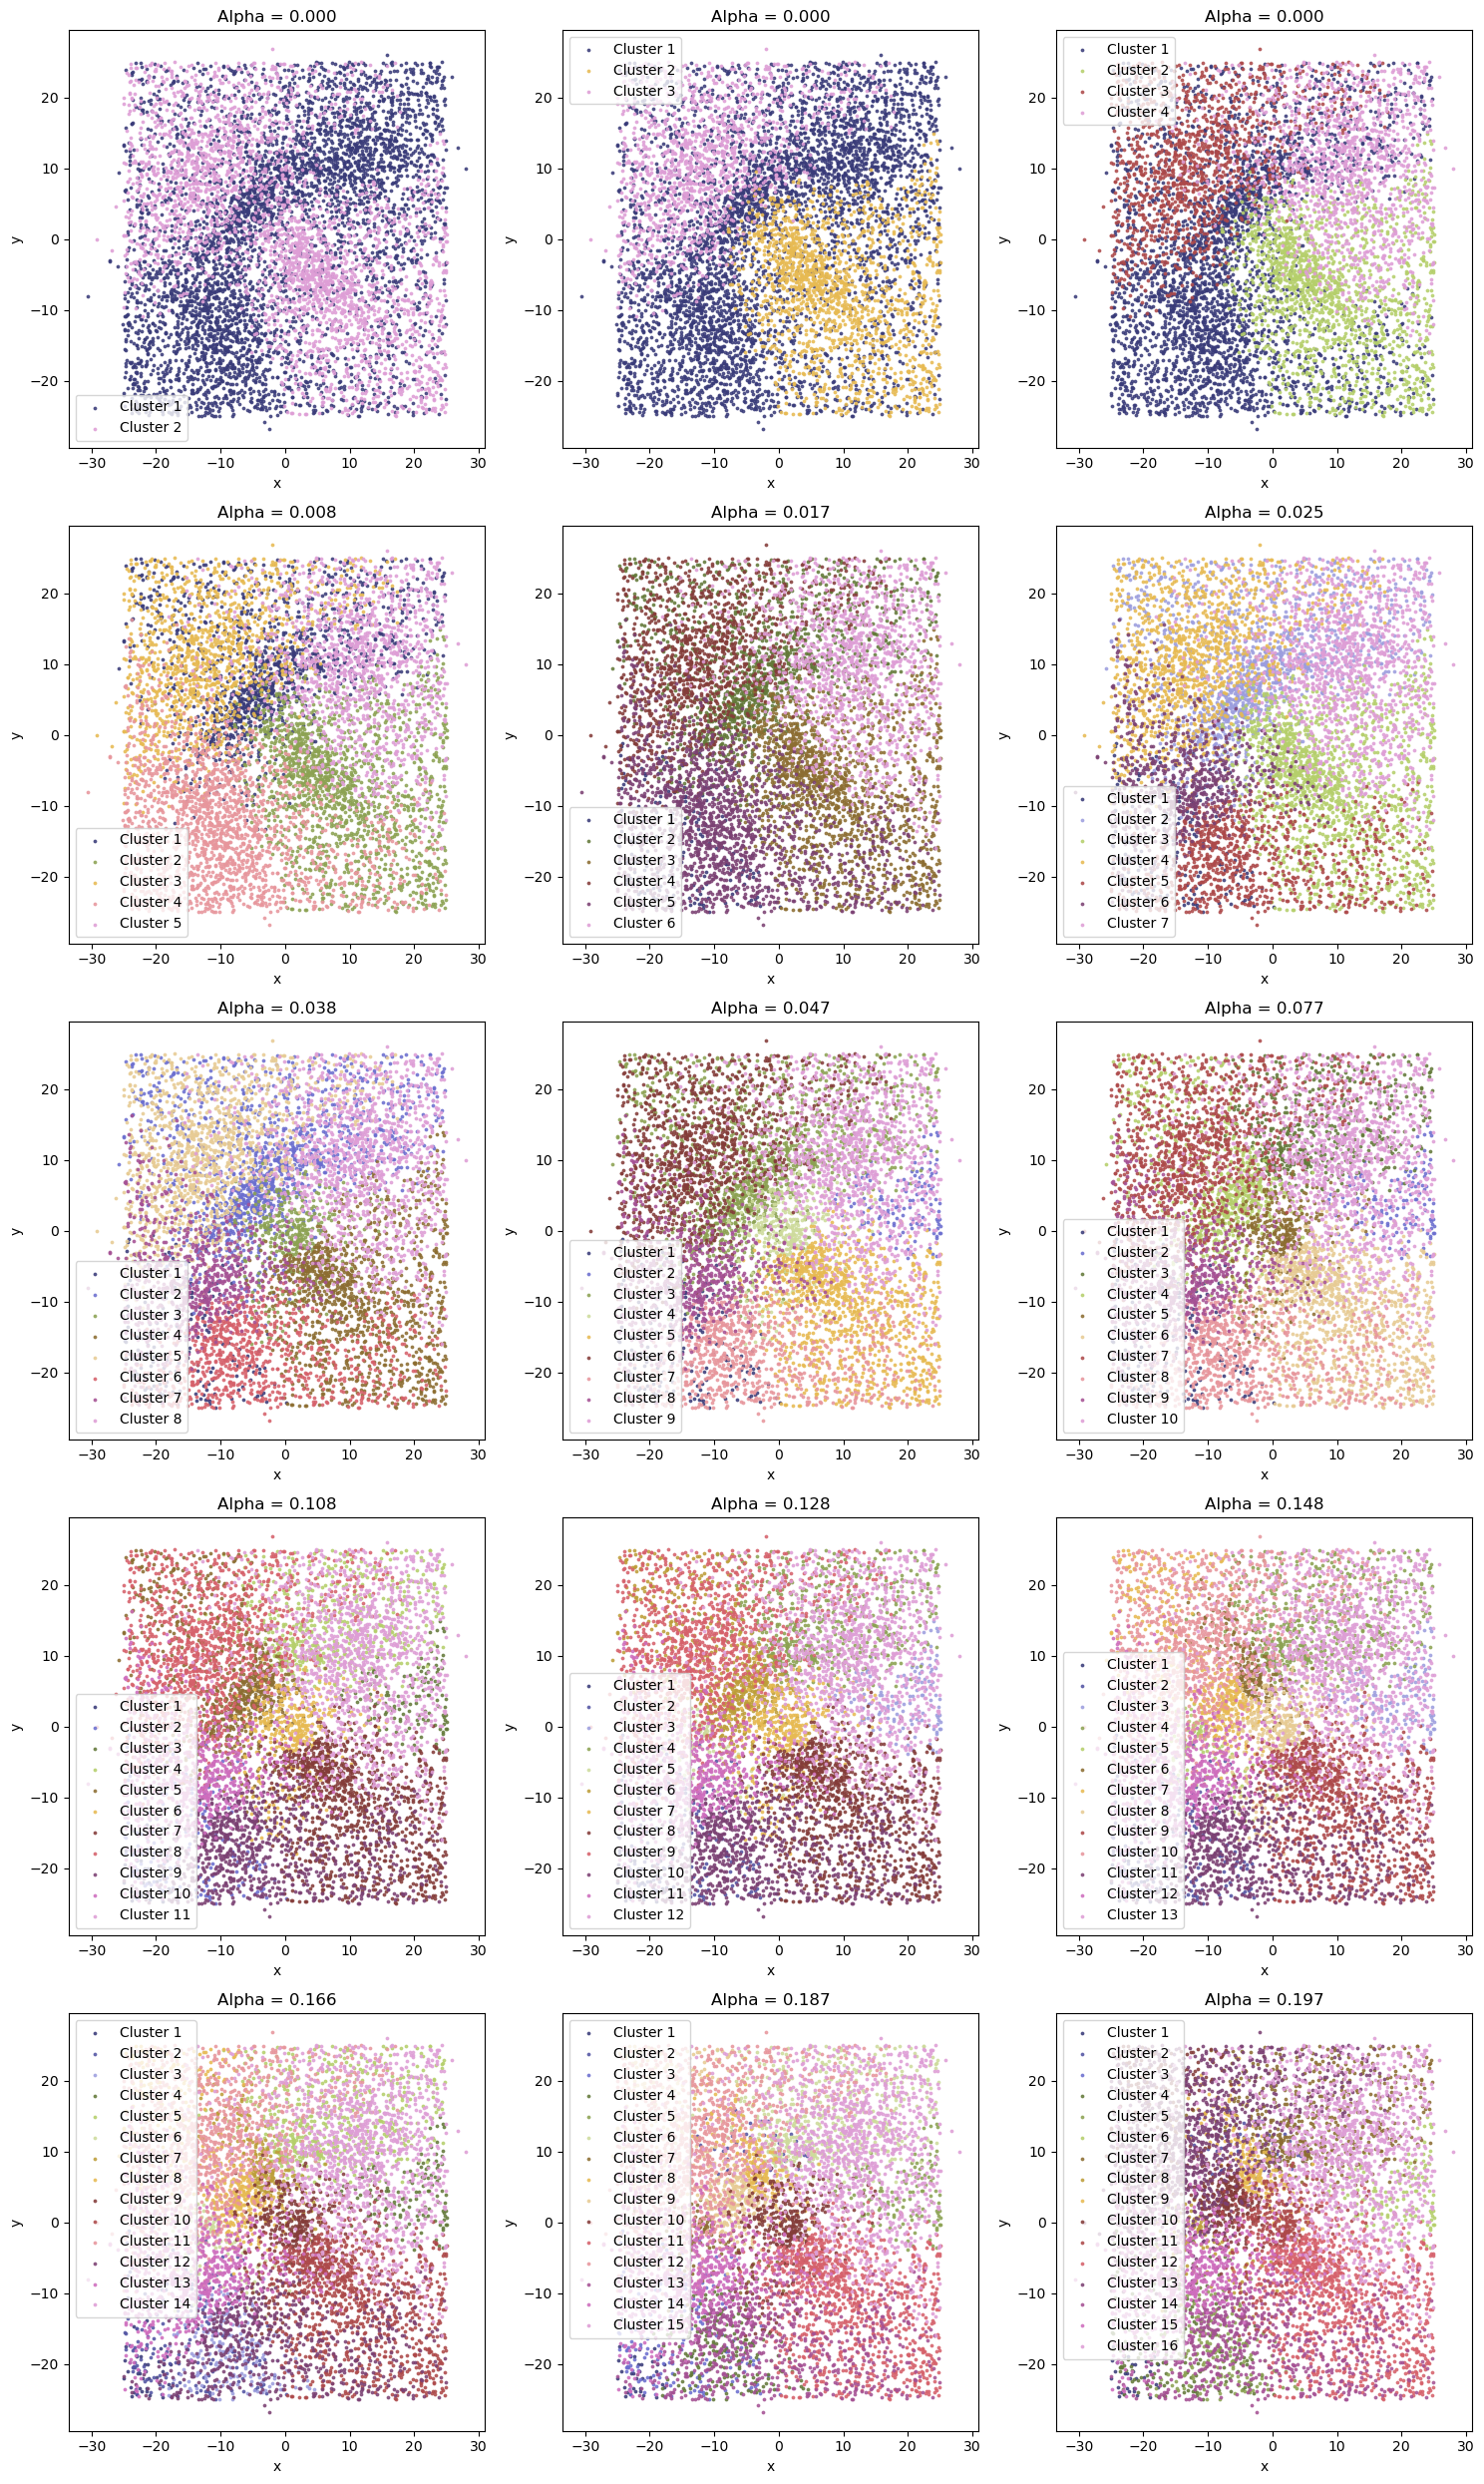

In [429]:
# dictionary to store results of merge_clusters for each alpha
merged_results = {}

# Run merge clustering for each alpha and store results
for alpha in alpha_values:
    merged_labels, merged_pvalues = clusterer.merge_clusters(knn=20, alpha=alpha)
    merged_results[alpha] = {
        "labels": merged_labels,
        "pvalues": merged_pvalues
    }

n_alpha = len(alpha_values)
cols = 3
rows = ceil(n_alpha / cols)

fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axs = axs.flatten()

for i, alpha in enumerate(alpha_values):
    merged_labels = merged_results[alpha]["labels"]
    unique_labels = np.unique(merged_labels)
    print(unique_labels)

    cmap = plt.get_cmap('tab20b', len(unique_labels))
    ax = axs[i]

    for j, label in enumerate(unique_labels):
        cluster_idx = np.where(merged_labels == label)[0]
        ax.scatter(df.loc[cluster_idx, x_col], df.loc[cluster_idx, y_col],
                   s=3, label=f'Cluster {j+1}', alpha=0.8, color=cmap(j))

    ax.set_title(f'Alpha = {alpha:.3f}')
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.legend()

# Hide unused subplots
for ax in axs[n_alpha:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### How are real labels represented in unique labels  


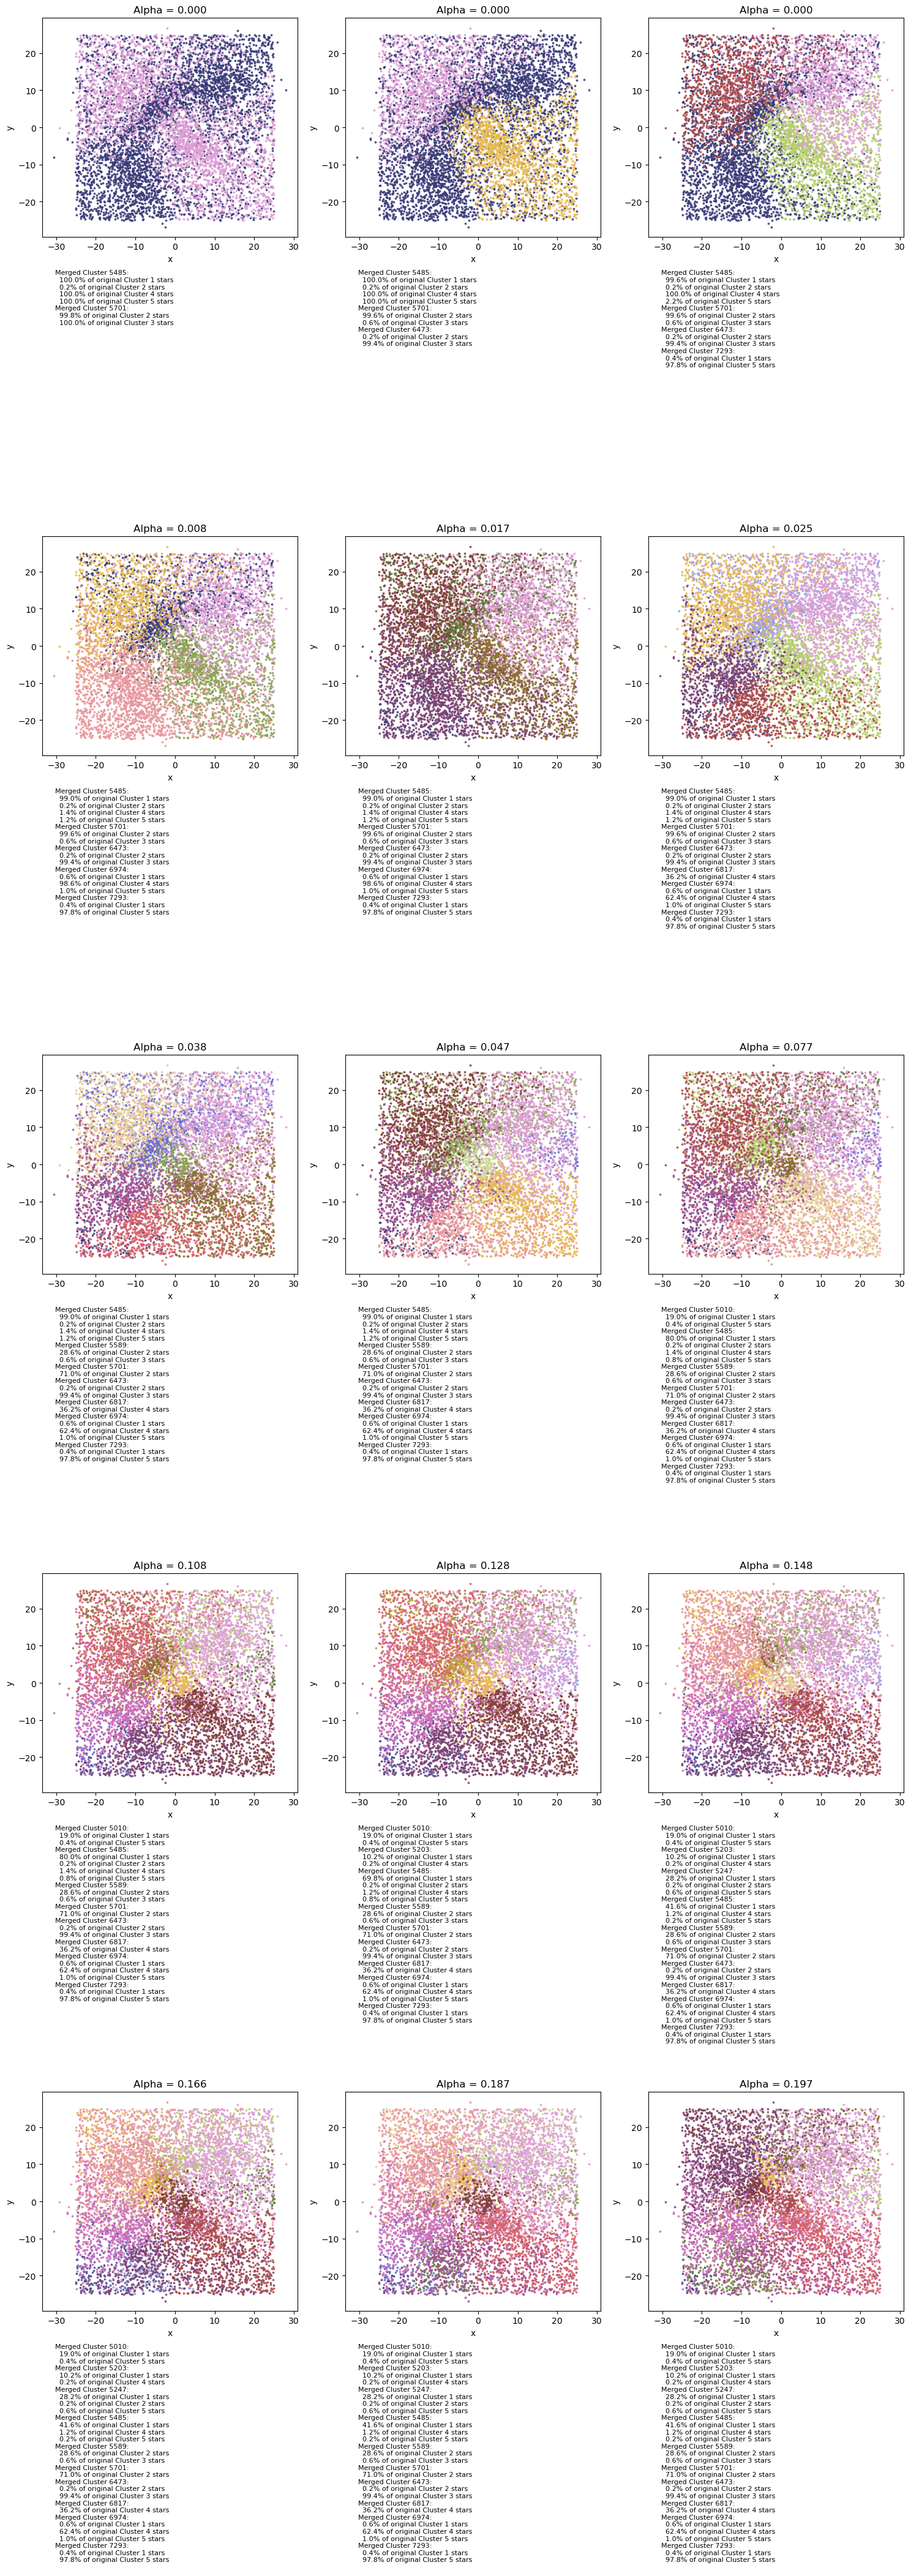

In [430]:
fig, axs = plt.subplots(rows, cols, figsize=(15, 8.5 * rows))
axs = axs.flatten()

# original clusters as dictionary
original_clusters = {
    1: idx_cluster_1,
    2: idx_cluster_2,
    3: idx_cluster_3,
    4: idx_cluster_4,
    5: idx_cluster_5
}

for i, alpha in enumerate(alpha_values):
    merged_labels = merged_results[alpha]["labels"]
    unique_labels = np.unique(merged_labels)
    cmap = plt.get_cmap('tab20b', len(unique_labels))

    # Initialize dictionary to store cluster distribution for display
    cluster_distribution = {}
    ax = axs[i]

    for j, label in enumerate(unique_labels):
        cluster_idx = np.where(merged_labels == label)[0]
        ax.scatter(df.loc[cluster_idx, x_col], df.loc[cluster_idx, y_col],
                   s=3, label=f'Cluster {j+1}', alpha=0.8, color=cmap(j))

        # Calculate distribution of original clusters within this merged cluster
        cluster_distribution[label] = {}
        for original_label, original_indices in original_clusters.items():
            common_indices = np.intersect1d(cluster_idx, original_indices)
            percentage = len(common_indices) / len(original_indices) * 100 if len(original_indices) > 0 else 0
            if percentage > 0:
                cluster_distribution[label][original_label] = percentage

    merge_info = ""
    for merged_label, distribution in cluster_distribution.items():
        if distribution:  # Only add if there's a non-zero percentage from any original clusters
            merge_info += f"Merged Cluster {merged_label}:\n"
            for original_label, percentage in distribution.items():
                merge_info += f"  {percentage:.1f}% of original Cluster {original_label} stars\n"
                
    ax.set_title(f'Alpha = {alpha:.3f}')
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.text(0.05, -0.15, merge_info, transform=ax.transAxes, fontsize=8, verticalalignment='top', wrap=True)

# Hide unused subplots
for ax in axs[n_alpha:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


# NMI plot (normalized_mutual_info_score)

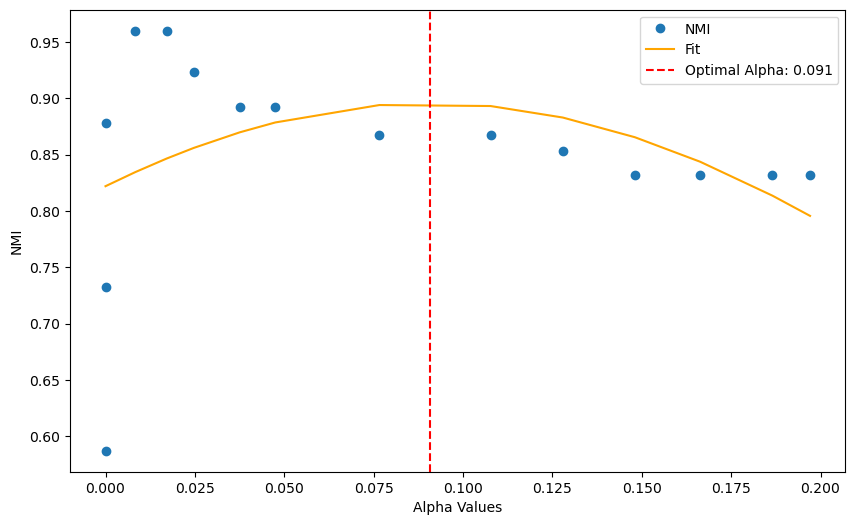

Optimal Alpha from fit: 0.091


In [431]:
labels_true = labels

# Gaussian fitting
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Calculate NMI for each alpha value
nmi_scores = []
for alpha in alpha_values:
    labels_pred = merged_results[alpha]["labels"]
    filtered_true_labels = labels_true[labels_true != 0] #all labels that are not background = 0
    filtered_pred_labels = labels_pred[labels_true != 0]

    nmi = normalized_mutual_info_score(filtered_true_labels, filtered_pred_labels)
    nmi_scores.append(nmi)

# Fit using Gaussian function
alpha_array = np.array(alpha_values[:len(nmi_scores)])
nmi_scores = np.array(nmi_scores)

popt, _ = curve_fit(gaussian, alpha_array, nmi_scores, p0=[1, np.mean(alpha_array), np.std(alpha_array)])

# determine optimal alpha
a, optimal_alpha, sigma = popt

# NMI against alpha values
# nmi plot all merged to all split
plt.figure(figsize=(10, 6))
plt.plot(alpha_array, nmi_scores, 'o', label='NMI')
plt.plot(alpha_array, gaussian(alpha_array, *popt), '-', label='Fit', color='orange')
plt.xlabel('Alpha Values')
plt.ylabel('NMI')
plt.axvline(optimal_alpha, color='r', linestyle='--', label=f'Optimal Alpha: {optimal_alpha:.3f}')
plt.legend()
plt.show()

# Output the optimal alpha from fitted curve
print(f'Optimal Alpha from fit: {optimal_alpha:.3f}')

# Quality of Splits
Does each split more damage or helps for every cluster?

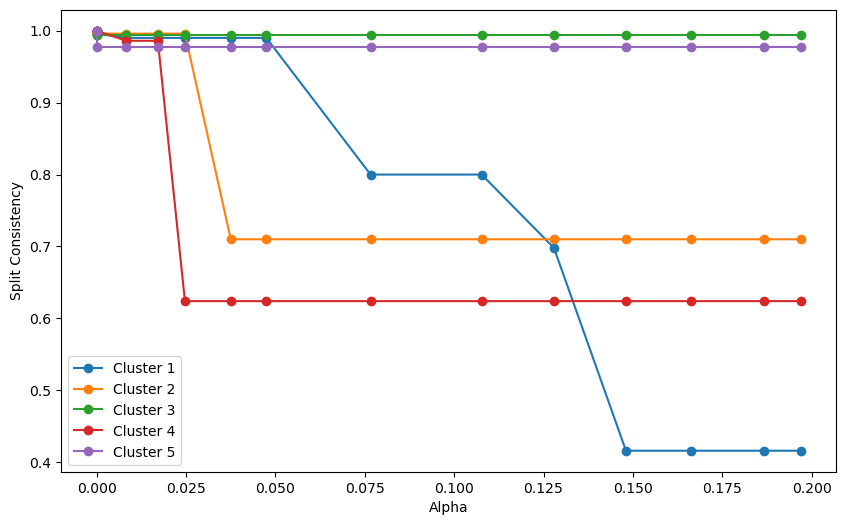

In [432]:
# Prepare a dictionary to store the split consistency for each cluster
split_consistency = {orig_label: [] for orig_label in original_clusters.keys()}

for alpha in alpha_values: #For each alpha calculate the fraction of points from the original clusters that remain together in the merged clusters.
    merged_labels = merged_results[alpha]["labels"]
    
    for orig_label, orig_indices in original_clusters.items():
        max_fraction = 0
        for merged_label in np.unique(merged_labels):
            merged_indices = np.where(merged_labels == merged_label)[0]
            overlap = len(np.intersect1d(orig_indices, merged_indices)) #Compute overlap of the original cluster with the merged clusters
            fraction = overlap / len(orig_indices)
            max_fraction = max(max_fraction, fraction)
        
        # Record the fraction for this original cluster at the current alpha
        split_consistency[orig_label].append(max_fraction)

# Plot the split consistency curves
plt.figure(figsize=(10, 6))
for orig_label, fractions in split_consistency.items():
    plt.plot(alpha_values, fractions, label=f"Cluster {orig_label}", marker='o')

plt.xlabel("Alpha")
plt.ylabel("Split Consistency")
plt.legend()
plt.show()


In [433]:
print(split_consistency)

{1: [1.0, 1.0, 0.996, 0.99, 0.99, 0.99, 0.99, 0.99, 0.8, 0.8, 0.698, 0.416, 0.416, 0.416, 0.416], 2: [0.998, 0.996, 0.996, 0.996, 0.996, 0.996, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71], 3: [1.0, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994, 0.994], 4: [1.0, 1.0, 1.0, 0.986, 0.986, 0.624, 0.624, 0.624, 0.624, 0.624, 0.624, 0.624, 0.624, 0.624, 0.624], 5: [1.0, 1.0, 0.978, 0.978, 0.978, 0.978, 0.978, 0.978, 0.978, 0.978, 0.978, 0.978, 0.978, 0.978, 0.978]}


# Implement Softmax algorithm (optimized)

### Optimal radial velocity class: VrOpt computes pairwise minimal 3D velocity difference (in Cartesian space) for a given set of stars

In [434]:
est = VrOpt(ra, dec, pmra, pmdec, dist)

### Build the distance matrix for clustering ourselves

In [435]:
# Lower triangular matrix indices
a, b = np.tril_indices(len(X), -1)
_, _, delta_v = est.vr_opt(a, b)

# Create pairwise distance matrix with delta_v entries
dist_v_opt = np.zeros((len(X), len(X)))
dist_v_opt[a, b] = delta_v
dist_v_opt[b, a] = delta_v

### Compute the semi-cohesion metric

In [436]:
# Compute semi-cohesion metric G (NxN)
G = np.copy(dist_v_opt)
G = np.full_like(G, np.sum(G, axis=0)/len(G)) + np.full_like(G, np.sum(G, axis=0)/len(G)).T - np.sum(G)/len(G)**2 - G

In [437]:
print(G.shape)

(7500, 7500)


### Prepare initial partition

In [438]:
#get initial partition from K-sets
#K=10
#initial_sets = clustering_algorithm.ksets_plus_optimized(G,K)
#n = G.shape[0]
#p_i_initial = np.zeros((n,K))
#for i in range(n):
 #   p_i_initial[i, initial_sets[i]] = 1

In [439]:
K = 6
merged_labels = merged_results[alpha_values[4]]['labels']
unique_labels, mapped_labels = np.unique(merged_labels, return_inverse=True)

n = G.shape[0]
p_i_initial = np.zeros((n, K))
for i in range(n):
    p_i_initial[i, mapped_labels[i]] = 1


### Run algorithm 

In [440]:
#Apply Softmax algorithm
p_i_opt, z_opt = clustering_algorithm.softmax_clustering_optimized_iphd(G, K,initial_partition =p_i_initial) # pi opt is clustering solution

Execution time (softmax): 0 minutes, 0 seconds and 223 ms
Number of iterations (softmax): 2


In [441]:
# get cluster labels and number of clusters
labels_softmax_opt= clustering_algorithm.get_clusters(p_i_opt)  #get clusters fct. removes columns only containing 0
unique_clusters = np.unique(labels_softmax_opt)
num_clusters = len(unique_clusters)
print(num_clusters)

6


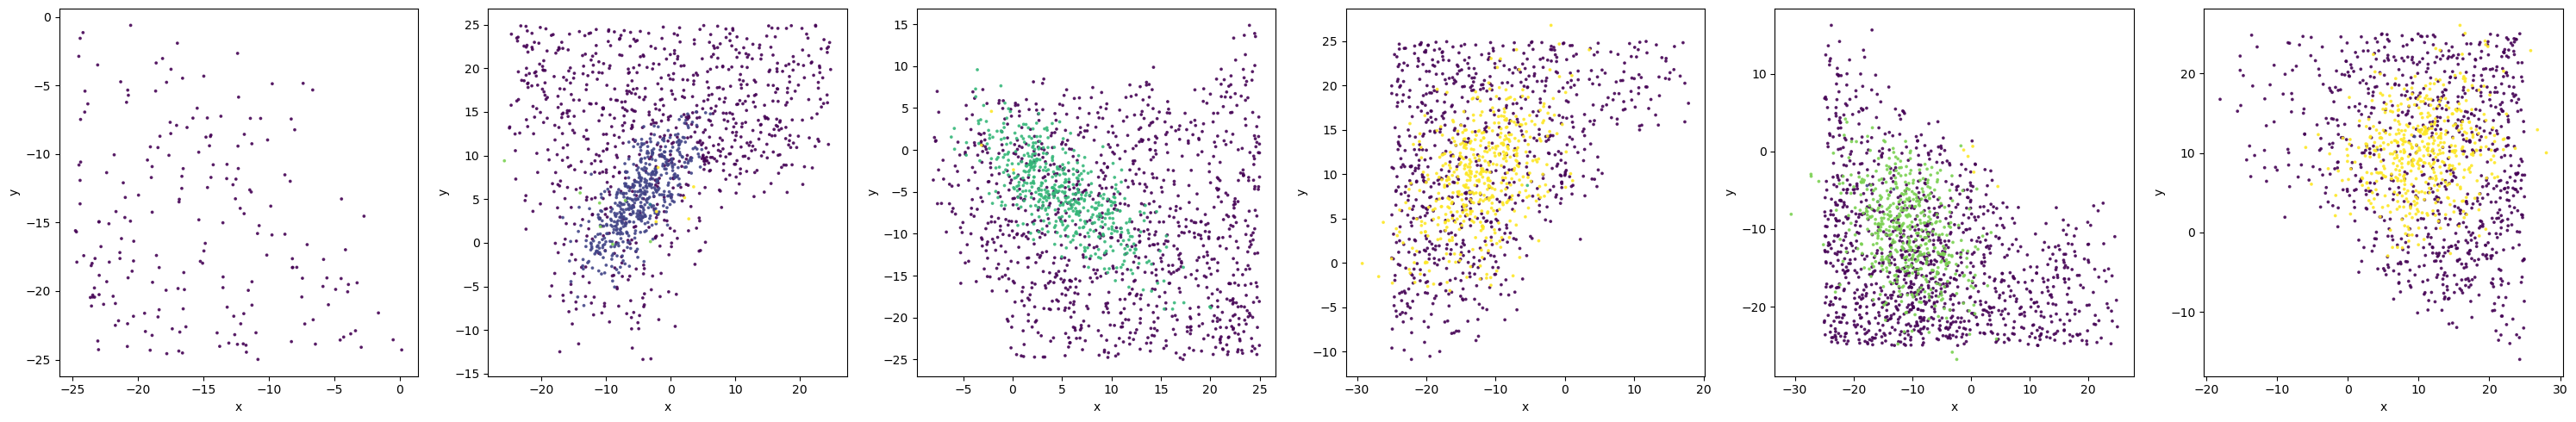

In [442]:
#plot solution (should: split into 5 clusters plus 6. cluster just noise)#x_col, y_col = 'x', 'y'
#x_col, y_col = 'pmra', 'pmdec'
#x_col, y_col = 'vt_ra', 'vt_dec'
x_col, y_col = 'x', 'y'
clustering_algorithm.plot_clusters(df, labels_softmax_opt, labels_true, num_clusters, x_col, y_col)

In [443]:
filtered_true_labels = labels_true[labels_true != 0]
nmi = normalized_mutual_info_score(filtered_true_labels, labels_softmax_opt[labels_true != 0])
print(nmi)

0.9598642275345227


## Grid search on hyperparameters
grid search bayesian hyperparameter opt -gp_minimize
whats best nmi for dataset 
fct to evaluate nmi, specify only use nmi of (need to know of -1 problem)

Iteration No: 1 started. Evaluating function at random point.
Execution time (softmax): 0 minutes, 0 seconds and 178 ms
Number of iterations (softmax): 2
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1937
Function value obtained: -0.9599
Current minimum: -0.9599
Iteration No: 2 started. Evaluating function at random point.
Execution time (softmax): 0 minutes, 0 seconds and 172 ms
Number of iterations (softmax): 2
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1870
Function value obtained: -0.9599
Current minimum: -0.9599
Iteration No: 3 started. Evaluating function at random point.
Execution time (softmax): 0 minutes, 0 seconds and 185 ms
Number of iterations (softmax): 2
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1943
Function value obtained: -0.9599
Current minimum: -0.9599
Iteration No: 4 started. Evaluating function at random point.
Execution time (softmax): 0 minutes, 0 seconds and 194 ms
Number of iteration

clustering_algorithm.ipynb:23: RuntimeWarning:

overflow encountered in exp

clustering_algorithm.ipynb:23: RuntimeWarning:

invalid value encountered in multiply

clustering_algorithm.ipynb:24: RuntimeWarning:

invalid value encountered in divide



Execution time (softmax): 0 minutes, 26 seconds and 717 ms
Number of iterations (softmax): 250
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 26.7177
Function value obtained: -0.0000
Current minimum: -0.9599
Iteration No: 8 started. Evaluating function at random point.


clustering_algorithm.ipynb:23: RuntimeWarning:

overflow encountered in exp

clustering_algorithm.ipynb:23: RuntimeWarning:

invalid value encountered in multiply

clustering_algorithm.ipynb:24: RuntimeWarning:

invalid value encountered in divide



Execution time (softmax): 0 minutes, 23 seconds and 621 ms
Number of iterations (softmax): 250
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 23.6296
Function value obtained: -0.0000
Current minimum: -0.9599
Iteration No: 9 started. Evaluating function at random point.
Execution time (softmax): 0 minutes, 0 seconds and 190 ms
Number of iterations (softmax): 2
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.1923
Function value obtained: -0.9599
Current minimum: -0.9599
Iteration No: 10 started. Evaluating function at random point.
Execution time (softmax): 0 minutes, 0 seconds and 201 ms
Number of iterations (softmax): 2
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 0.5282
Function value obtained: -0.9599
Current minimum: -0.9599
Iteration No: 11 started. Searching for the next optimal point.


clustering_algorithm.ipynb:23: RuntimeWarning:

overflow encountered in exp

clustering_algorithm.ipynb:23: RuntimeWarning:

invalid value encountered in multiply

clustering_algorithm.ipynb:24: RuntimeWarning:

invalid value encountered in divide



Execution time (softmax): 0 minutes, 23 seconds and 635 ms
Number of iterations (softmax): 250
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 23.8728
Function value obtained: -0.0000
Current minimum: -0.9599
Iteration No: 12 started. Searching for the next optimal point.
Execution time (softmax): 0 minutes, 0 seconds and 183 ms
Number of iterations (softmax): 2
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.4017
Function value obtained: -0.9599
Current minimum: -0.9599
Iteration No: 13 started. Searching for the next optimal point.
Execution time (softmax): 0 minutes, 0 seconds and 186 ms
Number of iterations (softmax): 2
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.4194
Function value obtained: -0.9599
Current minimum: -0.9599
Iteration No: 14 started. Searching for the next optimal point.
Execution time (softmax): 0 minutes, 0 seconds and 172 ms
Number of iterations (softmax): 2
I

clustering_algorithm.ipynb:23: RuntimeWarning:

overflow encountered in exp

clustering_algorithm.ipynb:23: RuntimeWarning:

invalid value encountered in multiply

clustering_algorithm.ipynb:24: RuntimeWarning:

invalid value encountered in divide



Execution time (softmax): 0 minutes, 24 seconds and 743 ms
Number of iterations (softmax): 250
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 25.0531
Function value obtained: -0.0000
Current minimum: -0.9599
Iteration No: 19 started. Searching for the next optimal point.
Execution time (softmax): 0 minutes, 0 seconds and 200 ms
Number of iterations (softmax): 2
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.4454
Function value obtained: -0.9599
Current minimum: -0.9599
Iteration No: 20 started. Searching for the next optimal point.
Execution time (softmax): 0 minutes, 0 seconds and 187 ms
Number of iterations (softmax): 2
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.4257
Function value obtained: -0.9599
Current minimum: -0.9599
Iteration No: 21 started. Searching for the next optimal point.
Execution time (softmax): 0 minutes, 0 seconds and 180 ms
Number of iterations (softmax): 2
I

Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.6976
Function value obtained: -0.9599
Current minimum: -0.9599
Iteration No: 46 started. Searching for the next optimal point.
Execution time (softmax): 0 minutes, 0 seconds and 185 ms
Number of iterations (softmax): 2
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 0.7357
Function value obtained: -0.9599
Current minimum: -0.9599
Iteration No: 47 started. Searching for the next optimal point.
Execution time (softmax): 0 minutes, 0 seconds and 179 ms
Number of iterations (softmax): 2
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 0.7868
Function value obtained: -0.9599
Current minimum: -0.9599
Iteration No: 48 started. Searching for the next optimal point.
Execution time (softmax): 0 minutes, 0 seconds and 180 ms
Number of iterations (softmax): 2
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 0.7306
Function v

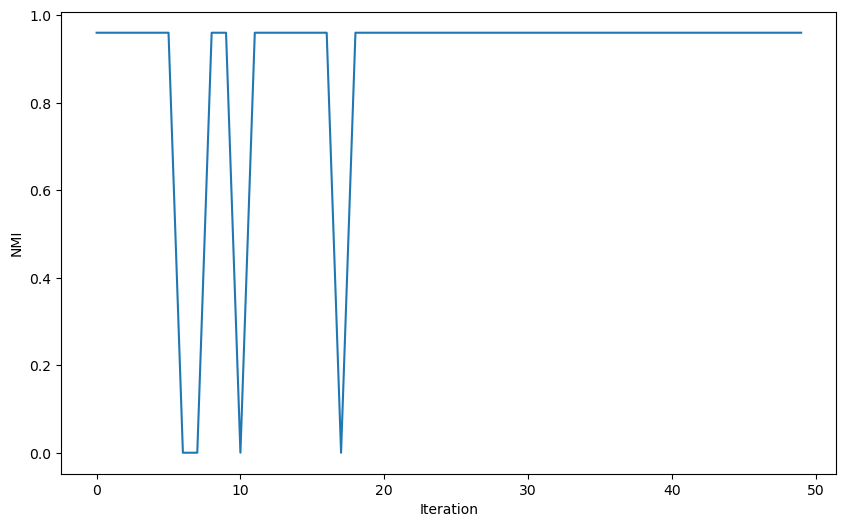

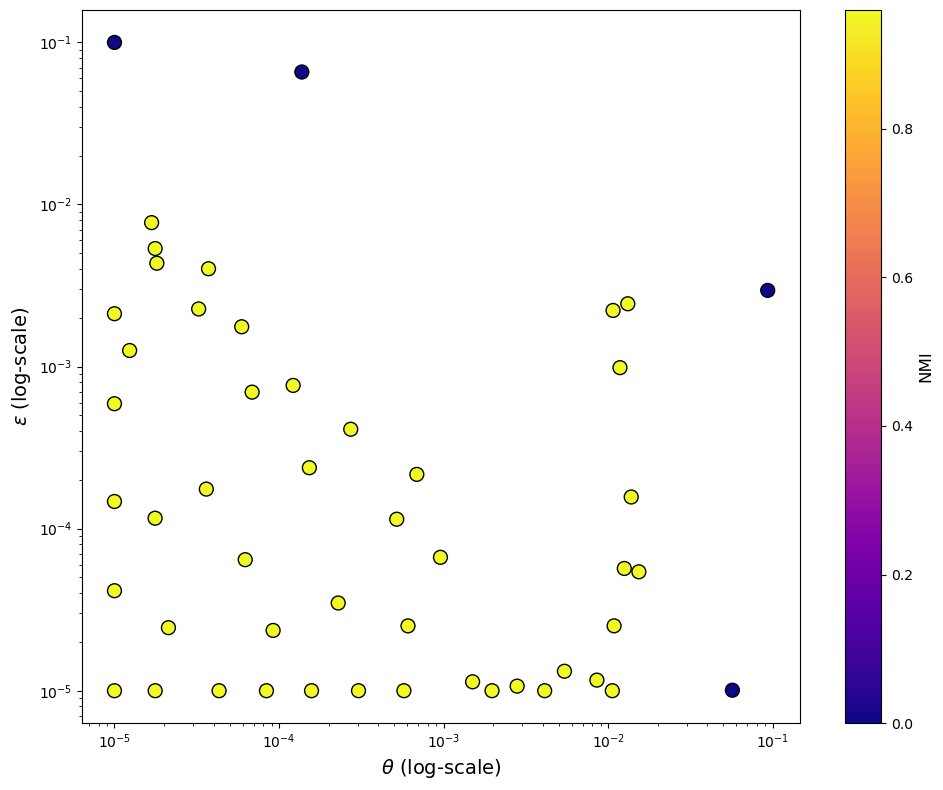

In [444]:
filtered_true_labels = labels_true[labels_true != 0]

# fct. to compute nmi for given hyperparameters
def compute_nmi(theta, epsilon):
    p_i_opt, _ = clustering_algorithm.softmax_clustering_optimized_iphd(G, K, theta=theta, epsilon=epsilon, max_iter=250,initial_partition =p_i_initial)
    labels_softmax_opt= clustering_algorithm.get_clusters(p_i_opt)  #get clusters fct. removes columns only containing 0

    nmi = normalized_mutual_info_score(filtered_true_labels, labels_softmax_opt[labels_true != 0])
    return nmi

# Define the parameter space
space = [
    Real(1e-5, 1e-1, "log-uniform", name="theta"),  # Log scale for theta
    Real(1e-5, 1e-1, "log-uniform", name="epsilon"),  # Log scale for epsilon
]

# Define the objective function for gp_minimize
@use_named_args(space)
def objective(**params):
    theta = params["theta"]
    epsilon = params["epsilon"]
    nmi = compute_nmi(theta, epsilon)
    return -nmi  # Minimize the negative NMI

# run bayesian optimization
res = gp_minimize(
    func=objective,
    dimensions=space,
    n_calls=50,  # Number of evaluations
    random_state=42,
    verbose=True
)

# Best parameters and corresponding nmi
best_theta, best_epsilon = res.x
best_nmi = -res.fun

print(f"Best theta: {best_theta}")
print(f"Best epsilon: {best_epsilon}")
print(f"Best NMI: {best_nmi}")

plt.figure(figsize=(10, 6))
plt.plot(-np.array(res.func_vals))
plt.xlabel("Iteration")
plt.ylabel("NMI")
plt.show()

# Plot parameter search space
theta_vals = [x[0] for x in res.x_iters]
epsilon_vals = [x[1] for x in res.x_iters]
nmi_vals = [-y for y in res.func_vals]

fig, ax = plt.subplots(figsize=(10, 8))

sc = ax.scatter(theta_vals, epsilon_vals, c=nmi_vals, cmap='plasma', s=100, edgecolor='k')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$\theta$ (log-scale)', fontsize=14)
ax.set_ylabel(r'$\epsilon$ (log-scale)', fontsize=14)

cb = plt.colorbar(sc)
cb.set_label('NMI', fontsize=12)

ax.tick_params(axis='both', which='both', labelsize=10)
plt.tight_layout()

plt.show()


In [462]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(
    go.Scatter3d(
        x=theta_vals,
        y=epsilon_vals,
        z=nmi_vals,
        mode='markers',
        marker=dict(
            size=8,
            color=nmi_vals,  
            colorscale='Viridis', 
            showscale=True,  
            colorbar=dict(title='NMI') 
        )
    )
)

fig.update_layout(
    scene=dict(
        xaxis=dict(title=r'$\theta$ (log-scale)', type='log'),
        yaxis=dict(title=r'$\epsilon$ (log-scale)', type='log'),
        zaxis=dict(title='NMI'),
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)
fig.show()

# Softmax on splitted data set

### Compute G splitted  G1 (mxm) and G2 (lxl), N = m+l

In [446]:
#Split G in 2
idx_g1 = 5485
idx_g2 = 5701

labels_pred = merged_results[alpha_values[0]]["labels"] #labels_pred for first splitting

G1 = G[np.ix_(labels_pred==idx_g1, labels_pred==idx_g1)]
G2 = G[np.ix_(labels_pred==idx_g2, labels_pred==idx_g2)]

In [447]:
print(G1.shape)
print(G2.shape)

(4612, 4612)
(2888, 2888)


In [448]:
#Run Softmax again on each G
p_i_opt_1, z_opt_1 = clustering_algorithm.softmax_clustering_optimized_iphd(G1, K) 
p_i_opt_2, z_opt_2 = clustering_algorithm.softmax_clustering_optimized_iphd(G2, K) 

Execution time (softmax): 0 minutes, 10 seconds and 292 ms
Number of iterations (softmax): 250
Execution time (softmax): 0 minutes, 3 seconds and 941 ms
Number of iterations (softmax): 233


In [449]:
# get cluster labels and number of clusters
labels_softmax_opt_g1= clustering_algorithm.get_clusters(p_i_opt_1)  #get clusters fct. removes columns only containing 0
labels_softmax_opt_g2= clustering_algorithm.get_clusters(p_i_opt_2)  #get clusters fct. removes columns only containing 0

unique_clusters_g1 = np.unique(labels_softmax_opt_g1)
unique_clusters_g2 = np.unique(labels_softmax_opt_g2)

num_clusters_g1 = len(unique_clusters_g1)
num_clusters_g2 = len(unique_clusters_g2)

print(num_clusters_g1)
print(num_clusters_g2)

4
5


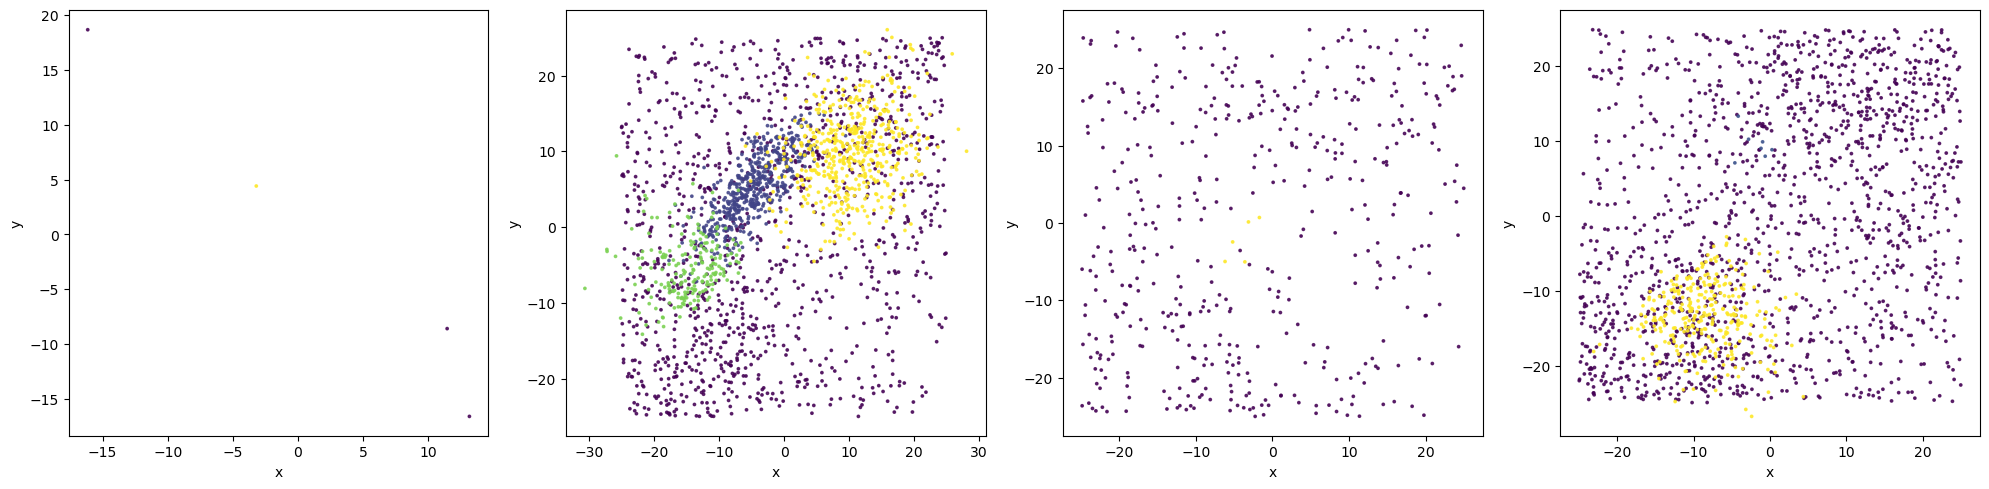

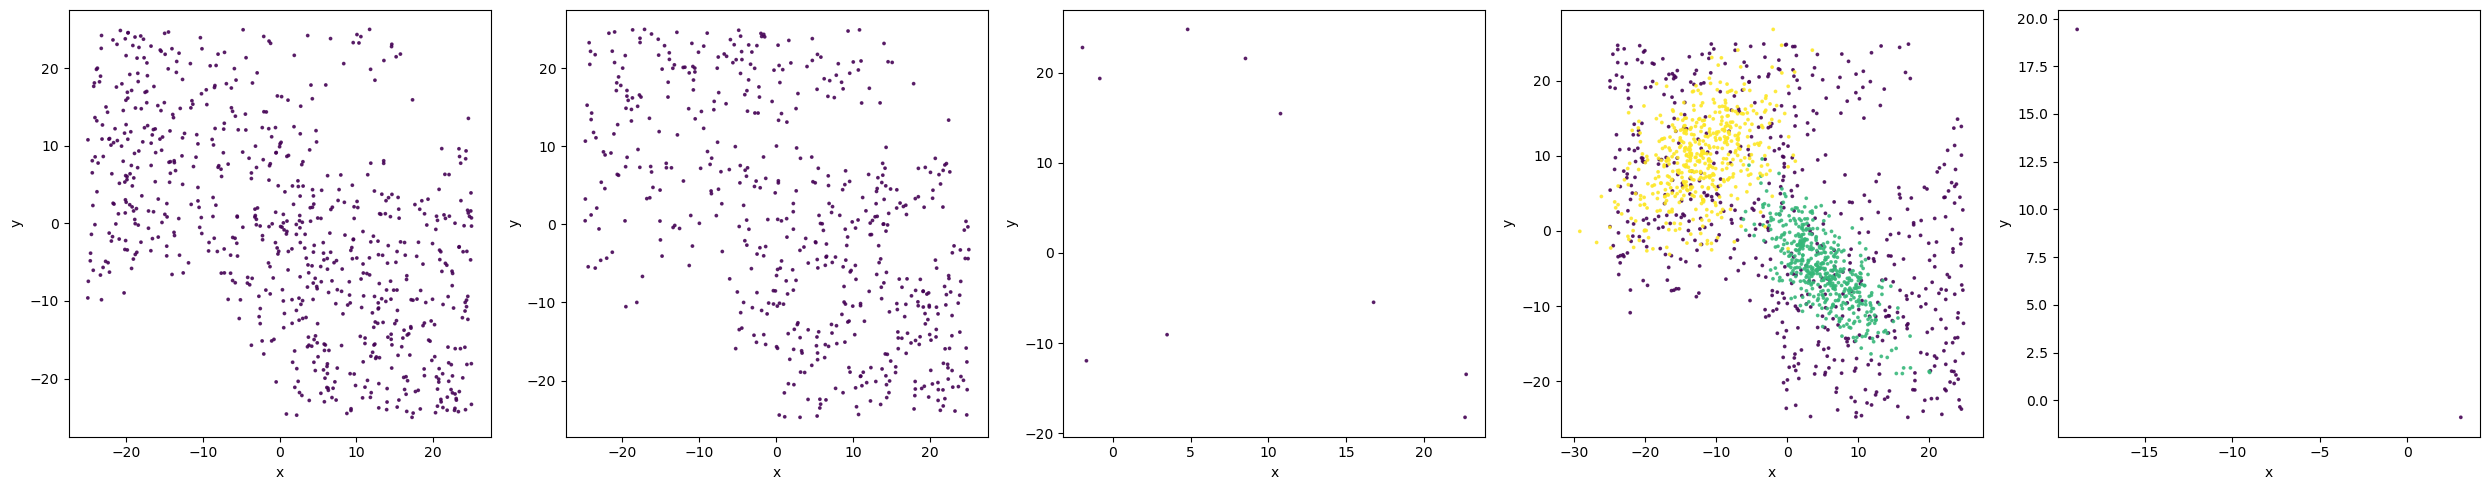

In [450]:
#plot solution (should: split into 5 clusters plus 6. cluster just noise)
x_col, y_col = 'x', 'y'
#x_col, y_col = 'pmra', 'pmdec'
#x_col, y_col = 'vt_ra', 'vt_dec'

#plot for G1
clustering_algorithm.plot_clusters(df[labels_pred == idx_g1],labels_softmax_opt_g1, labels_true[labels_pred == idx_g1], num_clusters_g1, x_col, y_col)
#plot for G2
clustering_algorithm.plot_clusters(df[labels_pred == idx_g2], labels_softmax_opt_g2,labels_true[labels_pred == idx_g2], num_clusters_g2, x_col, y_col)

### Compute NMI again 

In [451]:
# calculate NMI between original labels and each subset's labels
labels_true_g1=labels_true[labels_pred == idx_g1]
labels_true_g2=labels_true[labels_pred == idx_g2]

nmi_g1_original = normalized_mutual_info_score(labels_true_g1[labels_true_g1 != 0], labels_softmax_opt_g1[labels_true_g1 != 0])
nmi_g2_original = normalized_mutual_info_score(labels_true_g2[labels_true_g2 != 0], labels_softmax_opt_g2[labels_true_g2 != 0])

print(f"NMI original labels and G1 clustering: {nmi_g1_original}")
print(f"NMI original labels and G2 clustering: {nmi_g2_original}")

NMI original labels and G1 clustering: 0.3226534702594207
NMI original labels and G2 clustering: 0.0


In [452]:
np.unique(labels_softmax_opt_g2)

array([0, 1, 2, 3, 4], dtype=int64)

In [453]:
np.unique(labels_softmax_opt_g1)

array([0, 1, 2, 3], dtype=int64)

### Merge Clustering results
labels_softmax_opt for G1 and G2 -> merge cluster result of G1 G2 
attention on indexing 01 eg 012 -> 234

In [454]:
# Offset G2 labels
labels_softmax_opt_g2_offset = labels_softmax_opt_g2 + num_clusters_g1

# Create a new array for combined labels, initialized with -1 
labels_new = np.full(labels_pred.shape, -1, dtype=int)

labels_new[labels_pred == idx_g1] = labels_softmax_opt_g1  # Assign G1 labels
labels_new[labels_pred == idx_g2] = labels_softmax_opt_g2_offset  # Assign offset G2 labels

print(np.unique(labels_new))

[0 1 2 3 4 5 6 7 8]


### NMI again 

In [455]:
#nmi  - wird es besser - trenn mehr auf (komplett seperate zellen betrachten aber evt. 1 cluster kommt in mehreeren zellen vor)
#annahme nmi nimmt ab
nmi_new = normalized_mutual_info_score(labels_true[labels_true != 0], labels_new[labels_true != 0])
print(nmi_new)

0.6370082355604256


In [ ]:
#Make a separate class 
#class ts =  treeSigMA(d,alpha threshold)
#ts.next() gets labels of highest alpha
#each time you call 
#e alpha = 0 
#alphath = (...)
#remove noise function